Same as the first part of the Pleiades notebook, but the query grabs stars who have data in all of the color bands.

First, we install the necessary Packages:

In [ ]:
!pip install --pre astroquery[all]
!pip install git+https://github.com/KrishnaswamyLab/CATCH

Make sure we are running on GPU:

In [ ]:
from tensorflow.test import gpu_device_name
gpu_device_name()

'/device:GPU:0'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import the packages we'll need:

In [ ]:
import numpy as np
import pandas as pd
import sys

###### For Catch/Machine learning
import graphtools
from CATCH import catch
import matplotlib.pyplot as plt
import scprep

import phate
import sklearn
from sklearn.cluster import KMeans

import tasklogger
import collections
import warnings
from collections import defaultdict

from scipy.spatial.distance import pdist, cdist, squareform
warnings.simplefilter("ignore")

###### For the astronomy data
import astropy.units as u
from astropy.coordinates.sky_coordinate import SkyCoord
from astropy.units import Quantity
from astroquery.gaia import Gaia

## Some helper functions I wrote
sys.path.append('/content/drive/MyDrive/Colab Notebooks/Phys 678 Final Project')
from astro_dc_utils import *

## Running on the Cleaned Pleides Querey

In [ ]:
job2 = Gaia.launch_job_async("SELECT * \
FROM gaiaedr3.gaia_source \
WHERE CONTAINS(POINT('ICRS',gaiaedr3.gaia_source.ra,gaiaedr3.gaia_source.dec),CIRCLE('ICRS',56.75,24.1167,2))=1 \
AND abs(pmra_error/pmra)<0.01 \
AND abs(pmdec_error/pmdec)<0.01 \
AND pmra IS NOT NULL AND abs(pmra)>0 \
AND pmdec IS NOT NULL AND abs(pmdec)>0 \
AND phot_g_mean_mag IS NOT NULL \
AND phot_bp_mean_mag IS NOT NULL \
AND phot_rp_mean_mag IS NOT NULL;", dump_to_file=True)

j = job2.get_results()
#print(j['source_id']) 

In [ ]:
for col in list(j.columns):
  print(col)

Now, we construct a data matrix from the features we are interested in. We'll be doing this quite frequently, so we define a function for doing so:

In [ ]:
features = ['ra', 'dec', 'pmra', 'pmdec', 'parallax', 'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag']
X = build_dataframe_from_query(j, features)
print(X)

             ra        dec       pmra       pmdec   parallax  phot_g_mean_mag  \
0     57.064576  25.243313  19.155875  -42.056807   6.855481        17.047014   
1     57.040411  25.247193 -11.901480  -21.675584   1.535869        16.943745   
2     57.041104  25.269433 -36.103727 -135.939296  10.116181        14.874213   
3     57.066527  25.280966   4.793038   -4.497765   0.698988        15.396906   
4     57.099394  25.296269  47.024820  -20.131801   3.012670        15.795108   
...         ...        ...        ...         ...        ...              ...   
6484  55.768560  25.907422   8.096437  -15.088835   0.839964        16.248184   
6485  56.268506  25.984120  11.689102   -9.648314   3.525009        12.928019   
6486  56.246344  26.000993  30.194526  -38.892751   3.774213        18.995264   
6487  56.316053  26.036406  13.261324    6.276796   1.111789        15.367433   
6488  56.268876  26.027551  11.332236  -15.869316   0.960779        17.277565   

      phot_bp_mean_mag  pho

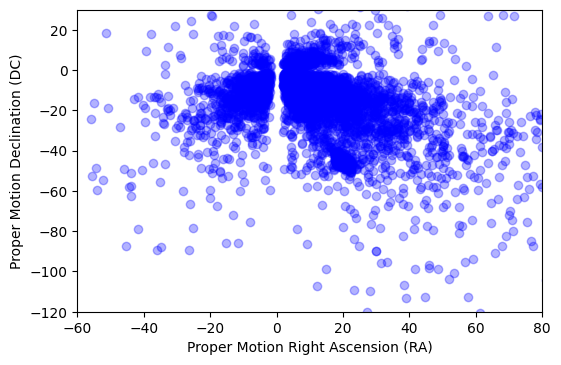

In [ ]:
fig = plt.figure(dpi=100)

plt.scatter(X['pmra'], X['pmdec'], color='b', alpha=0.3)
plt.xlabel('Proper Motion Right Ascension (RA)')
plt.ylabel('Proper Motion Declination (DC)')
plt.xlim(-60,80)
plt.ylim(-120,30)
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Phys 678 Final Project/figures/pmdec_vs_pmra_pleiades')
plt.show()

In [ ]:
catch_op = catch.CATCH(knn=20, random_state=18, n_pca=len(features), n_jobs=1)
catch_op.fit(X)

Calculating PCA...
Calculated PCA in 0.01 seconds.
Calculating Diffusion Condensation...
  Calculating Condensation Parameters...
  Calculated Condensation Parameters in 1.19 seconds.
Calculated Diffusion Condensation in 66.14 seconds.


Next, we identify granularities for downstream analysis using topological
activity analysis:

Calculating Topological Activity...
Calculated Topological Activity in 0.04 seconds.
[-97 -92 -82 -80 -74 -68 -64 -59 -52 -45 -43 -37 -31 -25]


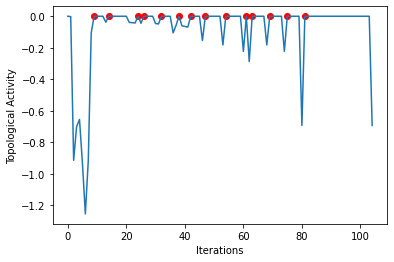

<Figure size 432x288 with 0 Axes>

In [ ]:
visualize_topology(catch_op, topological_activity=True)
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Phys 678 Final Project/figures/all_colors_topology')

Grab the source ids and their indices for real pleiades stars and escapee candidates:

In [ ]:
#### Run this to extract the real pleiades indices
# pleiades_table = np.loadtxt('/content/drive/MyDrive/Colab Notebooks/Phys 678 Final Project/pleiades_table.txt')
# pleiades_escapees = np.loadtxt('/content/drive/MyDrive/Colab Notebooks/Phys 678 Final Project/pleiades_escapees_table.txt')
# ids = [int(pleiades_table[i][0]) for i in range(pleiades_table.shape[0])]
# escapees = [int(pleiades_escapees[i][0]) for i in range(pleiades_escapees.shape[0])]
# pleiades = get_common_source_idxs(j, ids)
# escapee_locs = get_common_source_idxs(j, escapees)

#Result of the above (to speed things up)
pleiades = [2493, 3569, 5480, 5570, 4435, 2045, 3828, 4357, 4045, 4372, 2367, 3930, 3658, 4038, 1012, 2092, 5038, 5191, 4057, 2680, 1026, 3967, 2870, 5123, 4947, 2663, 5765, 1691, 3508, 2360, 3898, 5185, 3832, 6022, 5072, 3530, 5524, 2388, 3395, 3037, 3228, 4960, 5599, 82, 3515, 4115, 4642, 5456, 5161, 3632, 2920, 3380, 1709, 3926, 5186, 4454, 118, 56, 5250, 5597, 4476, 663, 6073, 1519, 5567, 5039, 4061, 3036, 4587, 2461, 2110, 6386, 5133, 3915, 5000, 4741, 3479, 2073, 1909, 3571, 1527, 2423, 5522, 4363, 4244, 3343, 4303, 3802, 1964, 3953, 5428, 5684, 3989, 4517, 2341, 5565, 1657, 5658, 4442, 4985, 2721, 1738, 5808, 5199, 4627, 1167, 3876, 4897, 4697, 2326, 4422, 1707, 2844, 4328, 5288, 2731, 3501, 3416, 4799, 5743, 5289, 5470, 5497, 5871, 5276, 1324, 2771, 2312, 5423, 4353, 5204, 5500, 3786, 1686, 1273, 3457, 2041, 4456, 5715, 2521, 5780, 6012, 3466, 2667, 1773, 4512, 4979, 1727, 50, 6428, 4139, 975, 5280, 5919, 4070, 4928, 4548, 5142, 5846, 3789, 3985, 3404, 4967, 2203, 5006, 2862, 5883, 4866, 435, 3988, 3957, 5779, 3539, 2744, 3271, 902, 1929, 3795, 4245, 4449, 3958, 4670, 4270, 6452, 607, 4566, 1178, 1708, 3820, 3092, 5981, 4450, 448, 4126, 5634, 2246, 5434, 5652, 4968, 4360, 3548, 5574, 5459, 5044, 2207, 206, 3864, 5091, 3683, 5279, 3752, 5146, 3933, 5609, 8, 4823, 6152, 4013, 4528, 2352, 1879, 4853, 4473, 3123, 4445, 4110, 4733, 2530, 2206, 4695, 4551, 587, 543, 5165, 321, 5087, 5075, 5638, 2843, 1842, 3591, 5150, 5195, 3462, 1649, 1120, 990, 4635, 5263, 5129, 4509, 4120, 3856, 4009, 1741, 5063, 3664, 5856, 1653, 5769, 3912, 1836, 4414, 4436, 1082, 865, 4801, 4106, 769, 5783, 4809, 2422, 2921, 4323, 3709, 474, 3778, 2217, 6278, 419, 3998, 5375, 5408, 4085, 5725, 3956, 4467, 4401, 5242, 5972, 5007, 6222, 4668, 5243, 1750, 2661, 5564, 5556, 5458, 3687, 3182, 3295, 3364, 6251, 6402, 3159, 5011, 5460, 4783, 1444, 3884, 5790, 4613, 4044, 3790, 1540, 5182, 2315, 3990, 4712, 5010, 5318, 5825, 1722, 5735, 3872, 3950, 969, 3496, 2613, 2560, 6157, 5509, 4027, 5882, 2400, 5710, 3377, 3910, 5618, 3282, 4451, 5921, 5068, 4472, 2960, 933, 1728, 3318, 1656, 2039, 5717, 4178, 5499, 1805, 5396, 1634, 3431, 1884, 5722, 1564, 4488, 4506, 5872, 4083, 5079, 4887, 4934, 5076, 1341, 4610, 5515, 242, 4990, 425, 4792, 1702, 3337, 2516, 5467, 323, 80, 4690, 5835, 3860, 5469, 1361, 6341, 210, 1380, 4264, 4850, 6414, 6067, 5164, 1819, 5873, 4184, 3452, 4616, 6127, 670, 1744, 5763, 5537, 5529, 3963, 4310, 2313, 2153, 3922, 5380, 3863, 1935, 5103, 1250, 3923, 2371, 1565, 4582, 5894, 1284, 2032, 6441, 4932, 5265, 4938, 3453, 2852, 6202, 1688, 4493, 3408, 4342, 999, 5610, 3626, 3914, 4946, 1947, 1751, 6258, 1931, 5781, 4018, 3254, 4332, 4041, 2669, 4939, 3870, 410, 3433, 4718, 4994, 4986, 6349, 2714, 3762, 1481, 5262, 4017, 5080, 4394, 2399, 4875, 4894, 2861, 3313, 2644, 4677, 6267, 4441, 1039, 5463, 29, 561, 1346, 4498, 2666, 4208, 1562, 2385, 97, 125, 6094, 3807, 5268, 3793, 1375, 3189, 5391, 3797, 2397, 5533, 5015, 5153, 4862, 900, 1814, 5492, 3961, 2449, 3987, 3399, 5226, 1071, 3588, 5202, 1099, 1689, 2693, 3696, 3847, 4387, 2503, 2860, 5999, 4555, 5422, 6017, 5979, 3406, 4358, 510, 2123, 568, 5498, 1467, 5885, 3979, 2456, 5036, 3128, 2453, 5527, 5244, 5056, 5552, 6436, 3284, 6139, 1979, 6141, 3724, 2849, 4709, 236, 3409, 4274, 2497, 6307, 5319, 1394, 288, 3688, 5712, 2221, 5366, 1102, 2489, 6083, 2416, 751, 3719, 2582, 4366, 4003, 3659, 3995, 2222, 6032, 840, 1367, 4046, 2697, 4468, 5532, 3703, 4390, 3947, 4581, 4313, 2228, 6174, 5925, 4020, 4220, 4398, 3808, 4728, 1948, 3792, 3925, 5439, 2034, 2031, 2459, 5449, 2458, 3054, 3323, 4144, 4426, 2491, 5721, 4170, 4515, 3849, 2504, 3824, 1388, 4047, 2470, 5052, 1077, 2308, 4630, 3833, 1340, 5141, 2258, 3993, 2735, 1775, 3071, 57, 2746, 5035, 1300, 5635, 5645, 4200, 4893, 4434, 3969, 4333, 1397, 4906, 1546, 1739, 5009, 820, 3725, 4012, 2267, 2448, 1904, 3928, 888, 4001, 4168, 2089, 3819, 1572, 2098, 2376, 4251, 4966, 3198, 963, 5382, 1217, 5898, 1363, 5081, 3973, 2934, 5002, 5330, 2549, 5392, 501, 1119, 1219, 4362, 4389, 3920, 3327, 5455, 6163, 2457, 3799, 6417, 4452, 1556, 2106, 3348, 3396, 1818, 1241, 625, 5742, 2902, 4778, 4214, 4198, 5180, 3999, 4913, 5163, 1850, 3426, 1665, 1529, 5965, 2964, 6276, 2534, 3602, 2200, 3763, 5451, 5359, 5312, 4052, 3976, 1043, 3865, 1970, 5854, 3858, 5101, 5651, 2335, 5298, 4804, 5365, 5358, 5900, 5030, 3720, 1894, 2214, 4511, 5160, 4154, 181, 3852, 2019, 3503, 128, 1573, 3492, 2010, 5611, 1733, 3975, 1237, 4977, 883, 4645, 855, 4383, 468, 1607, 1214, 3927, 5546, 1606, 4826, 4090, 3480, 4249, 1466, 4822, 1553, 2043, 3579, 1986, 1463, 5468, 5841, 5374, 2454, 2065, 5531, 1240, 4227, 4858, 3853, 2627, 829, 735, 4890, 3901, 6315, 5261, 1609, 5198, 5116, 3938, 5176, 5370, 2446, 2127, 2501, 564, 5092, 5019, 4969, 4134, 4681, 771, 5104, 3886]
escapee_locs = [5508, 782, 2657, 1800, 3557, 2299, 1844]

Calculating Topological Activity...
Calculated Topological Activity in 0.02 seconds.


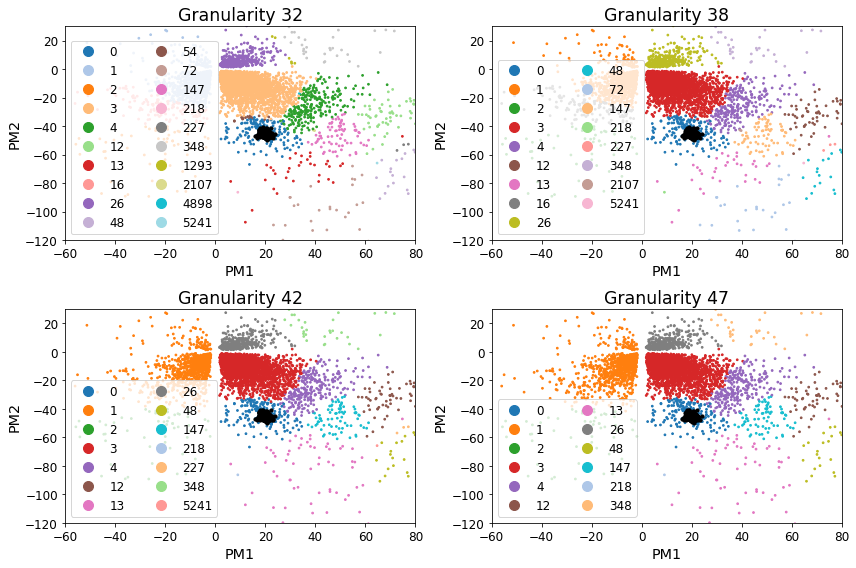

In [ ]:
granulated_feature_plot(j, catch_op, real_idxs=pleiades, custom_levels=[4, 5, 6, 7])#custom_levels=[0, 1, 2, 3]
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Phys 678 Final Project/figures/all_colors_granulated_feature')

Next, we run some KMeans for comparison:

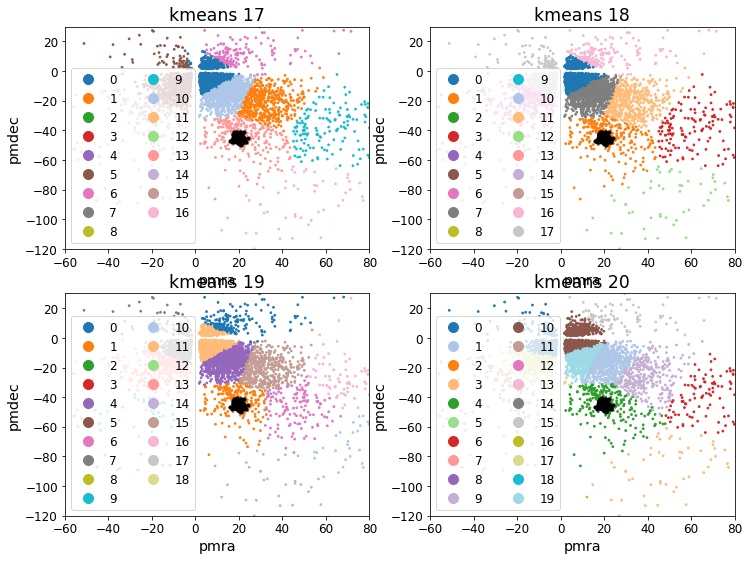

In [ ]:
k_means_feature_plot(X, Ns=[17, 18, 19, 20], features=['pmra', 'pmdec'], real_idxs=pleiades)
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Phys 678 Final Project/figures/all_colors_kmeans')

Now we can compute the condensation homology and visualize some of these stable clusters on the tree to help us identify optimal granularities levels for downstream analysis:

Calculating Topological Activity...
Calculated Topological Activity in 0.04 seconds.
Calculating PHATE...
  Running PHATE on 6489 observations and 8 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 1.18 seconds.
    Calculating affinities...
    Calculated affinities in 0.10 seconds.
  Calculated graph and diffusion operator in 1.32 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 1.43 seconds.
    Calculating KMeans...
    Calculated KMeans in 20.69 seconds.
  Calculated landmark operator in 23.82 seconds.
  Calculating optimal t...
    Automatically selected t = 28
  Calculated optimal t in 4.54 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 3.35 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 5.78 seconds.
Calculated PHATE in 38.86 seconds.


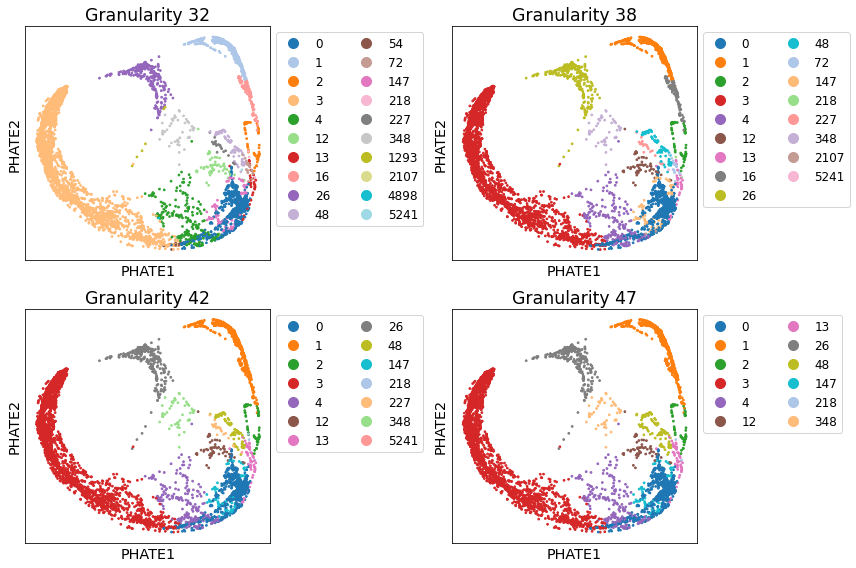

In [ ]:
plot_phate_granularities(X, catch_op, None, custom_levels=[4, 5, 6, 7])
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Phys 678 Final Project/figures/velocity_only_phate_granularities')
#plot_phate_granularities(X, catch_op)